### Step Model reconstructions

This notebook utilises the 'Step Model' discussed in _Good et al. (2011)_, _Good et al. (2013)_, _Bouttes et al. (2013)_, etc. to reconstruct the response to arbtirary forcings from an abrupt step forcing.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from scipy import signal
from xhistogram.xarray import histogram
import cftime

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:35091 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,24764
1,1deg_jra55_ryf_rcp45warm_x1_spinup500,42426
2,1deg_jra55_ryf_rcp45cool_x1_spinup500,42426
3,1deg_jra55_ryf_warm_0sat_8dwlw_spinup500,21206
4,1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500,21206
5,1deg_jra55_ryf_RCPwarm_humid_x1,42426
6,1deg_jra55_ryf_RCPwarm_humid_x2,42207
7,1deg_jra55_ryf_RCPcool_humid_x1,42207
8,1deg_jra55_ryf_RCPcool_humid_x2,42426
9,1deg_jra55_ryf_wcwc_step_test1,2108


In [4]:
yr_beg = cftime.DatetimeNoLeap(2400, 1, 7, 0, 0, 0, 0)
yr_end = cftime.DatetimeNoLeap(2500, 2, 15, 0, 0, 0, 0)

expt = '1deg_jra55_ryf_cont'
var = 'temp_global_ave'
frequency = '1 daily'
gat_cont = cc.querying.getvar(expt, var, session, frequency = frequency).sel(time=slice(yr_beg, yr_end)).chunk(chunks='auto')

In [5]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'temp_global_ave'
frequency = '1 daily'
gat_coolx1 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [6]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'temp_global_ave'
frequency = '1 daily'
gat_warmx1 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [7]:
expt = '1deg_jra55_ryf_sinusoid_x1_period2'
var = 'temp_global_ave'
frequency = '1 daily'
gat_period2 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [8]:
expt = '1deg_jra55_ryf_sinusoid_x1_period5'
var = 'temp_global_ave'
frequency = '1 daily'
gat_period5 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [9]:
expt = '1deg_jra55_ryf_sinusoid_x1_period10'
var = 'temp_global_ave'
frequency = '1 daily'
gat_period10 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

In [10]:
expt = '1deg_jra55_ryf_sinusoid_x1_period20'
var = 'temp_global_ave'
frequency = '1 daily'
gat_period20 = cc.querying.getvar(expt, var, session, frequency = frequency).chunk(chunks='auto') 

#### Reconstruction using warm_x1

In [47]:
gat_cont.load()
#gat_coolx1.load()
gat_warmx1.load()
gat_period2.load()
gat_period5.load()
gat_period10.load()

<xarray.DataArray 'temp_global_ave' (time: 38325, scalar_axis: 1)>
array([[3.55489587],
       [3.55493459],
       [3.55499053],
       ...,
       [3.52935029],
       [3.52938343],
       [3.5294363 ]])
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) object 2400-01-02 00:00:00 ... 2505-01-01 00:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: point
    standard_name:  sea_water_potential_temperature

In [26]:
# time = np.arange(1, 101)

# def w_step(step, time):
#     years = time.size
#     w_j = np.ones(years) * step # Starting at year 1, going to year 100
#     w_i = np.append(0, w_j[:-1]) # Starting at year 0, going to year 99
#     dw = w_j - w_i
#     return dW

# def w_wcwc(step, time, period_year):
#     years = time.size
#     #w_j = step * np.sign(np.sin((2 * np.pi / period_year) * time)) # Starting at year 1, going to year 100
#     w_j = np.tile(np.append(step * np.ones(int(period_year / 2)), - step * np.ones(int(period_year / 2))), int(years / period_year)) # Starting at year 1, going to year 100
#     w_i = np.append(0, w_j[:-1]) # Starting at year 0, going to year 99
#     dw = w_j - w_i
#     return dw

# years = 100
# period_year = 10
# step = 1
# w_j = np.tile(np.append(step * np.ones(int(period_year / 2)), - step * np.ones(int(period_year / 2))), int(years / period_year))
# w_i = np.append(0, w_j[:-1])
# w_j - w_i

# w_wcwc10 = w_wcwc(1, time, 20)
# w_cwcw10 = w_wcwc(- 1, time, 20)
# w_wcwc1 = w_wcwc(1, time, 2)
# w_wcwc25 = w_wcwc(1, time, 50) 

# plt.plot(np.append(0.0, np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_wcwc10)[:temp_cont_ave.shape[0]]))
# plt.plot(np.append(0.0, np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_cwcw10)[:temp_cont_ave.shape[0]]))
# plt.plot(np.append(0.0, np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_wcwc1)[:temp_cont_ave.shape[0]]))
# plt.plot(np.append(0.0, np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_wcwc25)[:temp_cont_ave.shape[0]]))

In [48]:
time = np.linspace(0, 100, gat_warmx1.shape[0] + 1)

def sinusoidal(time, period_year):
    years = time.size
    w_j = np.sin(2 * np.pi * time / period_year)
    return np.diff(w_j)

gat_period2_reconstruct = np.append(0.0, np.convolve((gat_warmx1 - gat_cont)[:,0], sinusoidal(time, 2))[:gat_cont.shape[0]-1])
gat_period5_reconstruct = np.append(0.0, np.convolve((gat_warmx1 - gat_cont)[:,0], sinusoidal(time, 5))[:gat_cont.shape[0]-1])
gat_period10_reconstruct = np.append(0.0, np.convolve((gat_warmx1 - gat_cont)[:,0], sinusoidal(time, 10))[:gat_cont.shape[0]-1])
gat_period20_reconstruct = np.append(0.0, np.convolve((gat_warmx1 - gat_cont)[:,0], sinusoidal(time, 20))[:gat_cont.shape[0]-1])

('-1.6742168675264013e+22 J, difference integrated over the 100 years',
 '-1.5874168975320668e+22 J, nonlinear response integrated over the 100 years',
 '8.679996999434454e+20 J, linearised integrated over the 100 years')

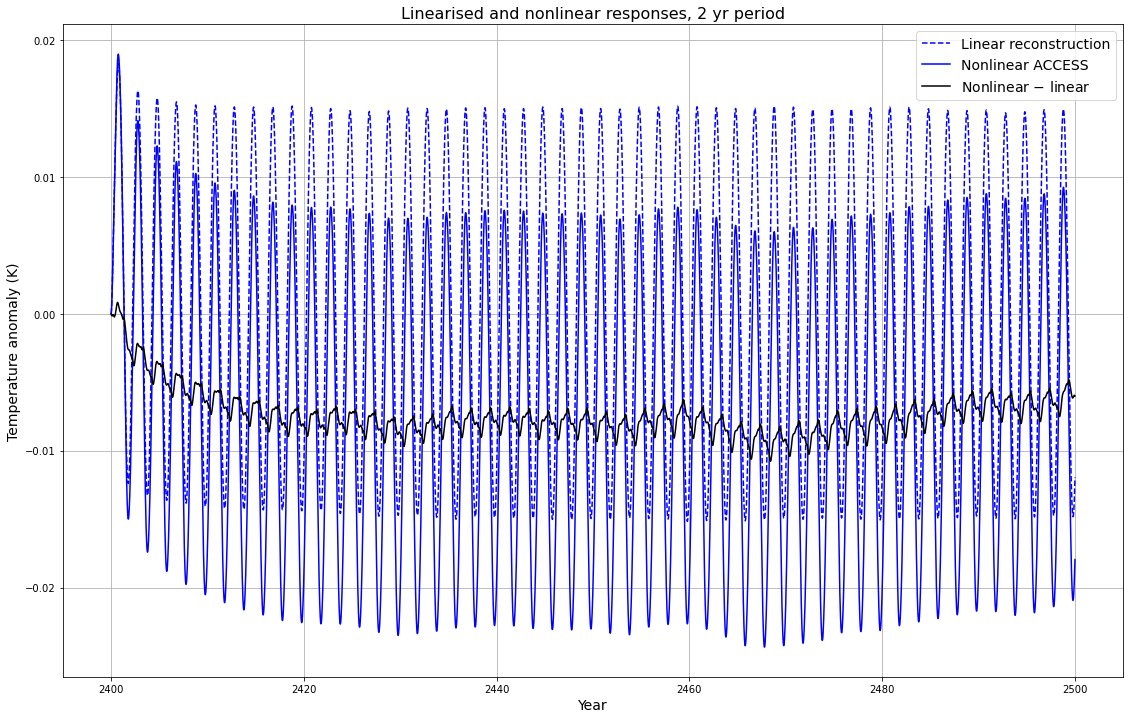

In [49]:
plt.figure(figsize=(19,12))

linear = gat_period2_reconstruct[:-50]
nonlinear = (gat_period2 - gat_cont)[:,0].values[:-50]
t = np.linspace(2400, 2500, linear.shape[0])

plt.plot(t, linear, label='Linear reconstruction', color = 'b', linestyle = '--')
plt.plot(t, nonlinear, label='Nonlinear ACCESS', color = 'b')
plt.plot(t, nonlinear - linear, label='Nonlinear $-$ linear', color = 'k')
plt.title('Linearised and nonlinear responses, 2 yr period', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature anomaly (K)', fontsize=14)
plt.grid()
plt.legend(fontsize=14)

f'{(np.cumsum(nonlinear - linear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, difference integrated over the 100 years', \
f'{(np.cumsum(nonlinear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, nonlinear response integrated over the 100 years', \
f'{(np.cumsum(linear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, linearised integrated over the 100 years'
#plt.savefig('step_model_2yr_period.jpg')

('-3.190017002364194e+22 J, difference integrated over the 100 years',
 '-2.987739709448077e+22 J, nonlinear response integrated over the 100 years',
 '2.0227729291610738e+21 J, linearised integrated over the 100 years')

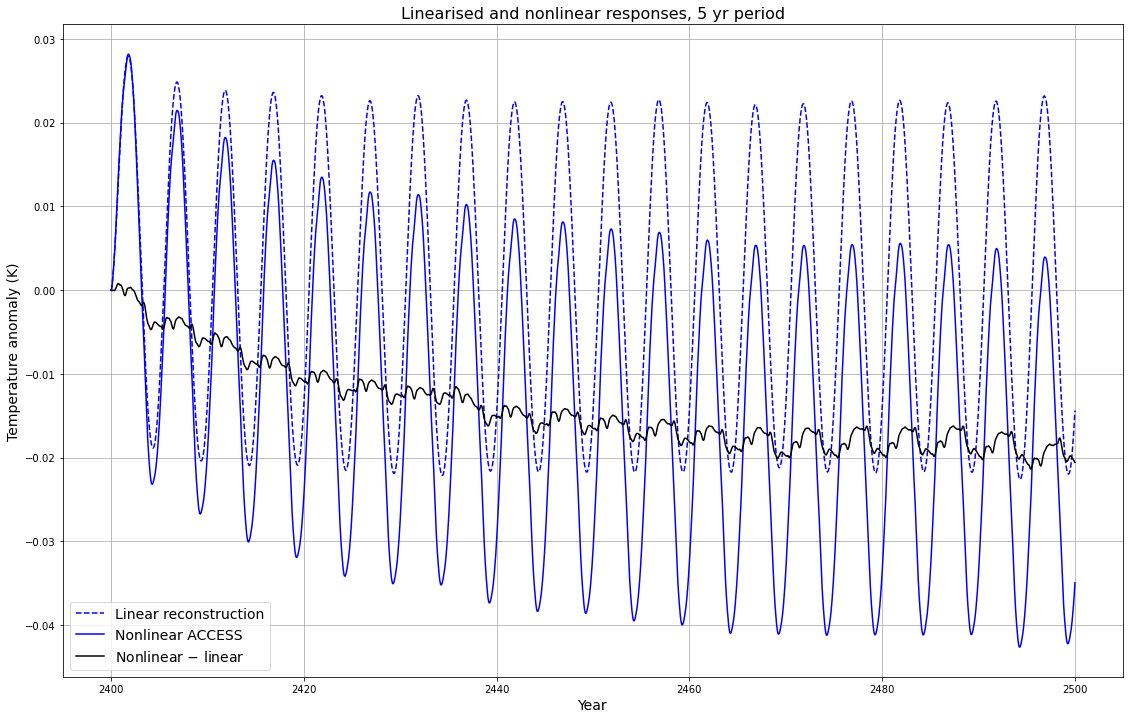

In [51]:
plt.figure(figsize=(19,12))

linear = gat_period5_reconstruct[:-50]
nonlinear = (gat_period5 - gat_cont)[:,0].values[:-50]
t = np.linspace(2400, 2500, linear.shape[0])

plt.plot(t, linear, label='Linear reconstruction', color = 'b', linestyle = '--')
plt.plot(t, nonlinear, label='Nonlinear ACCESS', color = 'b')
plt.plot(t, nonlinear - linear, label='Nonlinear $-$ linear', color = 'k')
plt.title('Linearised and nonlinear responses, 5 yr period', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature anomaly (K)', fontsize=14)
plt.grid()
plt.legend(fontsize=14)

f'{(np.cumsum(nonlinear - linear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, difference integrated over the 100 years', \
f'{(np.cumsum(nonlinear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, nonlinear response integrated over the 100 years', \
f'{(np.cumsum(linear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, linearised integrated over the 100 years'
# plt.savefig('step_model_5yr_period.jpg')

('-3.620201355421585e+22 J, difference integrated over the 100 years',
 '-3.2491880457946477e+22 J, nonlinear response integrated over the 100 years',
 '3.710133096269395e+21 J, linearised integrated over the 100 years')

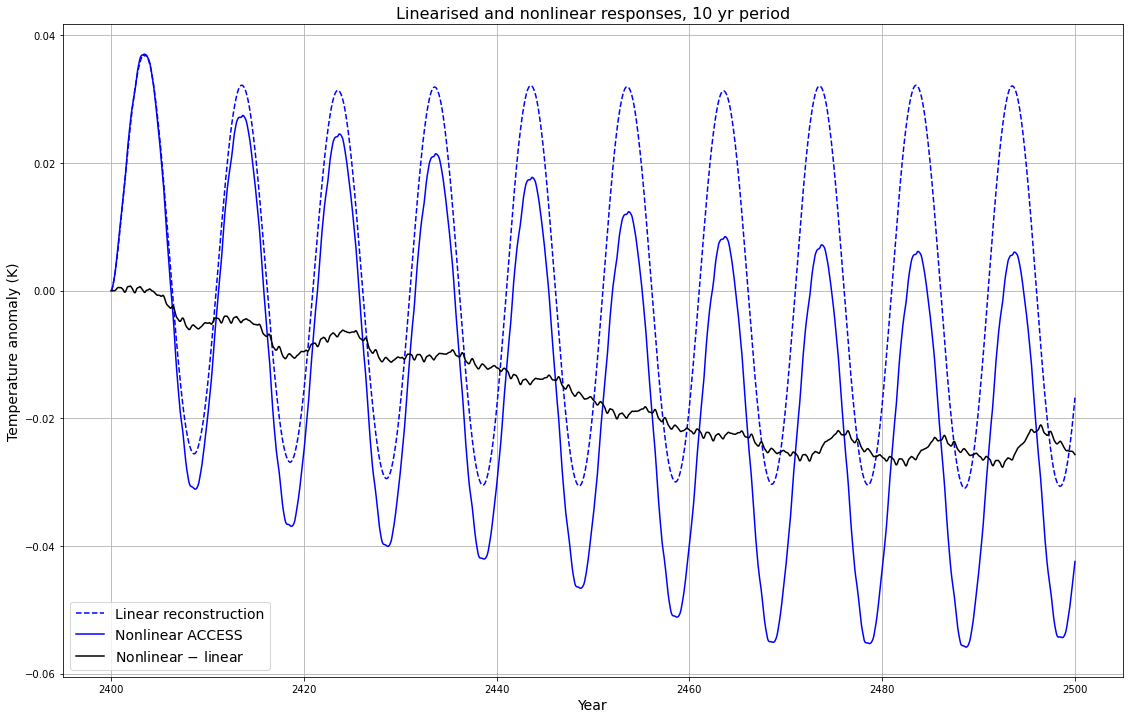

In [52]:
plt.figure(figsize=(19,12))

linear = gat_period10_reconstruct[:-50]
nonlinear = (gat_period10 - gat_cont)[:,0].values[:-50]
t = np.linspace(2400, 2500, linear.shape[0])

plt.plot(t, linear, label='Linear reconstruction', color = 'b', linestyle = '--')
plt.plot(t, nonlinear, label='Nonlinear ACCESS', color = 'b')
plt.plot(t, nonlinear - linear, label='Nonlinear $-$ linear', color = 'k')
plt.title('Linearised and nonlinear responses, 10 yr period', fontsize=16)
plt.ylabel('Temperature anomaly (K)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature anomaly (K)', fontsize=14)
plt.grid()
plt.legend(fontsize=14)

f'{(np.cumsum(nonlinear - linear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, difference integrated over the 100 years', \
f'{(np.cumsum(nonlinear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, nonlinear response integrated over the 100 years', \
f'{(np.cumsum(linear) / 86400)[-1] * 4000 * 1035 * 1.3e18} J, linearised integrated over the 100 years'
# plt.savefig('step_model_10yr_period.jpg')

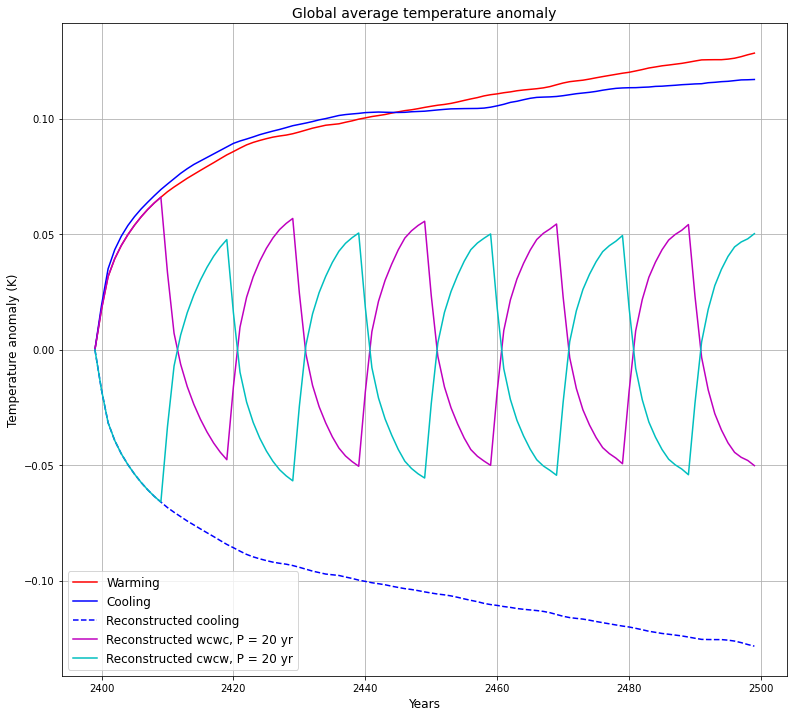

In [341]:
plt.figure(figsize = (13,12))

zero = xr.DataArray(data = [0], dims = 'year', coords = {"year": [2399]})
RCPwarm_humid_x1_anom = xr.concat([zero, temp_RCPwarm_humid_x1_ave - temp_cont_ave], dim = 'year')
RCPcool_humid_x1_anom = xr.concat([zero, temp_RCPcool_humid_x1_ave - temp_cont_ave], dim = 'year')

RCPcool_humid_x1_anom_reconstructed = xr.DataArray(np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_cool)[:temp_cont_ave.shape[0]],
                                                   coords = temp_cont_ave.coords,
                                                   dims = 'year')
RCPcool_humid_x1_anom_reconstructed = xr.concat([zero, RCPcool_humid_x1_anom_reconstructed], dim = 'year')

cwcw10_anom_reconstructed = xr.DataArray(np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_cwcw10)[:temp_cont_ave.shape[0]],
                                        coords = temp_cont_ave.coords,
                                        dims = 'year')
cwcw10_anom_reconstructed = xr.concat([zero, cwcw10_anom_reconstructed], dim = 'year')

wcwc10_anom_reconstructed = xr.DataArray(np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_wcwc10)[:temp_cont_ave.shape[0]],
                                        coords = temp_cont_ave.coords,
                                        dims = 'year')
wcwc10_anom_reconstructed = xr.concat([zero, wcwc10_anom_reconstructed], dim = 'year')

wcwc1_anom_reconstructed = xr.DataArray(np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_wcwc1)[:temp_cont_ave.shape[0]],
                                        coords = temp_cont_ave.coords,
                                        dims = 'year')
wcwc1_anom_reconstructed = xr.concat([zero, wcwc1_anom_reconstructed], dim = 'year')

wcwc25_anom_reconstructed = xr.DataArray(np.convolve(temp_RCPwarm_humid_x1_ave - temp_cont_ave, w_wcwc25)[:temp_cont_ave.shape[0]],
                                        coords = temp_cont_ave.coords,
                                        dims = 'year')
wcwc25_anom_reconstructed = xr.concat([zero, wcwc25_anom_reconstructed], dim = 'year')


RCPwarm_humid_x1_anom.plot(label = 'Warming', color = 'r')
(-1 * RCPcool_humid_x1_anom).plot(label = 'Cooling', color = 'b')
(1 * RCPcool_humid_x1_anom_reconstructed).plot(label = 'Reconstructed cooling', color = 'b', linestyle = '--')

#wcwc25_anom_reconstructed.plot(label = 'Reconstructed wcwc, P = 50 yr', color = 'm')
wcwc10_anom_reconstructed.plot(label = 'Reconstructed wcwc, P = 20 yr', color = 'm')#, linestyle = '--')
#wcwc1_anom_reconstructed.plot(label = 'Reconstructed wcwc, P = 2 yr', color = 'm', linestyle = '-.')

cwcw10_anom_reconstructed.plot(label = 'Reconstructed cwcw, P = 20 yr', color = 'c')


plt.title('Global average temperature anomaly', fontsize=14)
plt.ylabel('Temperature anomaly (K)', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
#plt.savefig('global_ave_temp_step-model.jpg')